# Analysis of DQN vs. PPO on Atari Pong

This notebook scans the `output/` directory for individual run folders, loads the `metrics.csv` from each, combines them into a master DataFrame, and then produces the learning curves and quantitative metrics for the paper.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## 1. Load Experiment Data

We scan `output/`, find all run directories, and load their respective `results/metrics.csv` files.

In [4]:
BASE_OUTPUT_DIR = '../output'
all_data = []

if not os.path.exists(BASE_OUTPUT_DIR):
    print(f"Error: Directory not found at '{BASE_OUTPUT_DIR}'. Please run training first.")
else:
    for run_dir_name in os.listdir(BASE_OUTPUT_DIR):
        run_path = os.path.join(BASE_OUTPUT_DIR, run_dir_name)
        csv_path = os.path.join(run_path, 'results', 'metrics.csv')
        
        if os.path.isfile(csv_path):
            try:
                parts = run_dir_name.rsplit('_', 1)
                agent_name = parts[0]
                seed = int(parts[1])
                
                df = pd.read_csv(csv_path)
                df['agent_name'] = agent_name
                df['seed'] = seed
                all_data.append(df)
            except Exception as e:
                print(f"Could not process {csv_path}: {e}")

if all_data:
    results_df = pd.concat(all_data, ignore_index=True)
    print("Data loaded successfully!")
    print(f"Found {results_df['agent_name'].nunique()} agents across {results_df['seed'].nunique()} unique seeds.")
    display(results_df.head())
else:
    print("No valid metrics.csv files found in the output directory.")

Data loaded successfully!
Found 2 agents across 3 unique seeds.


,environment_frame,wall_clock_time_seconds,fps,eval_mean_return,eval_std_return,epsilon,q_learning_loss,mean_q_value,agent_name,seed
0,25000,47.727894,523.802705,-21.0,0.0,1.0000,NaN,NaN,dqn_vanilla,126
1,50000,95.833601,521.737672,-21.0,0.0,1.0000,NaN,NaN,dqn_vanilla,126
2,75000,207.918163,360.718847,-21.0,0.0,0.9775,0.014578,0.025386,dqn_vanilla,126
3,100000,321.051018,311.476975,-21.0,0.0,0.9550,0.001136,-0.014756,dqn_vanilla,126
4,125000,435.257331,287.186432,-21.0,0.0,0.9325,0.000529,0.036398,dqn_vanilla,126


## 2. Plot Learning Curves

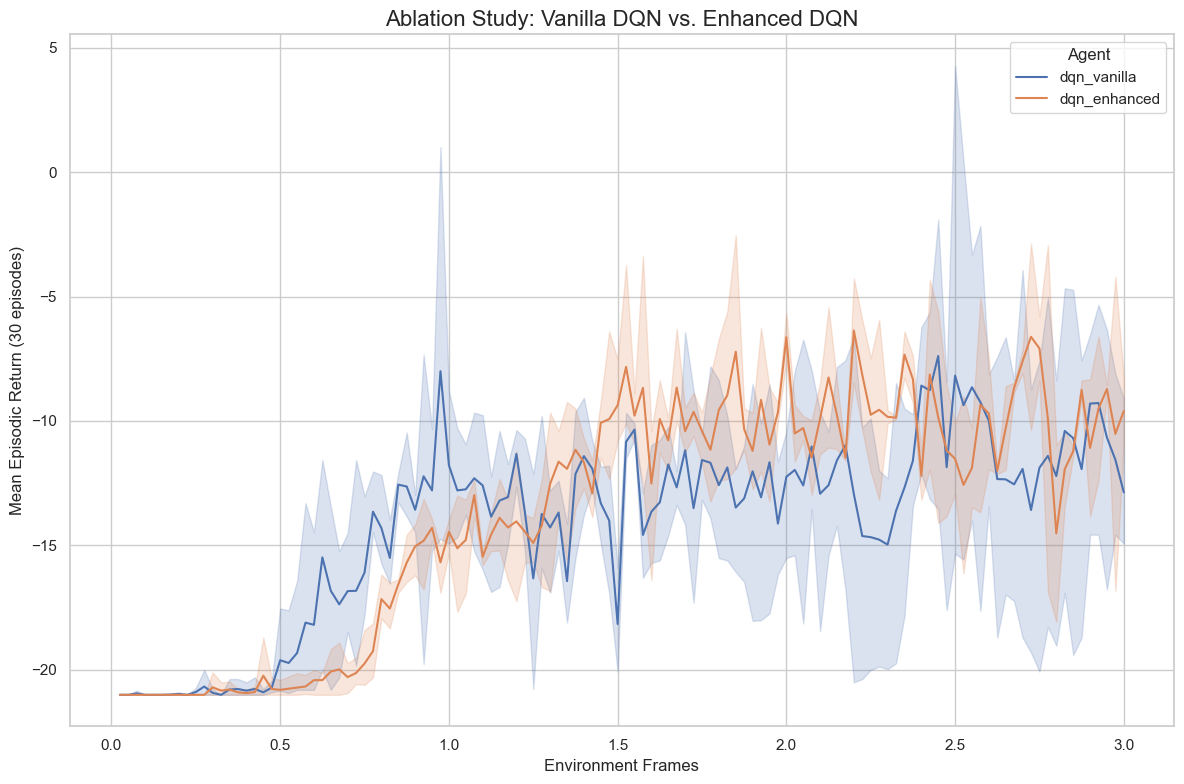

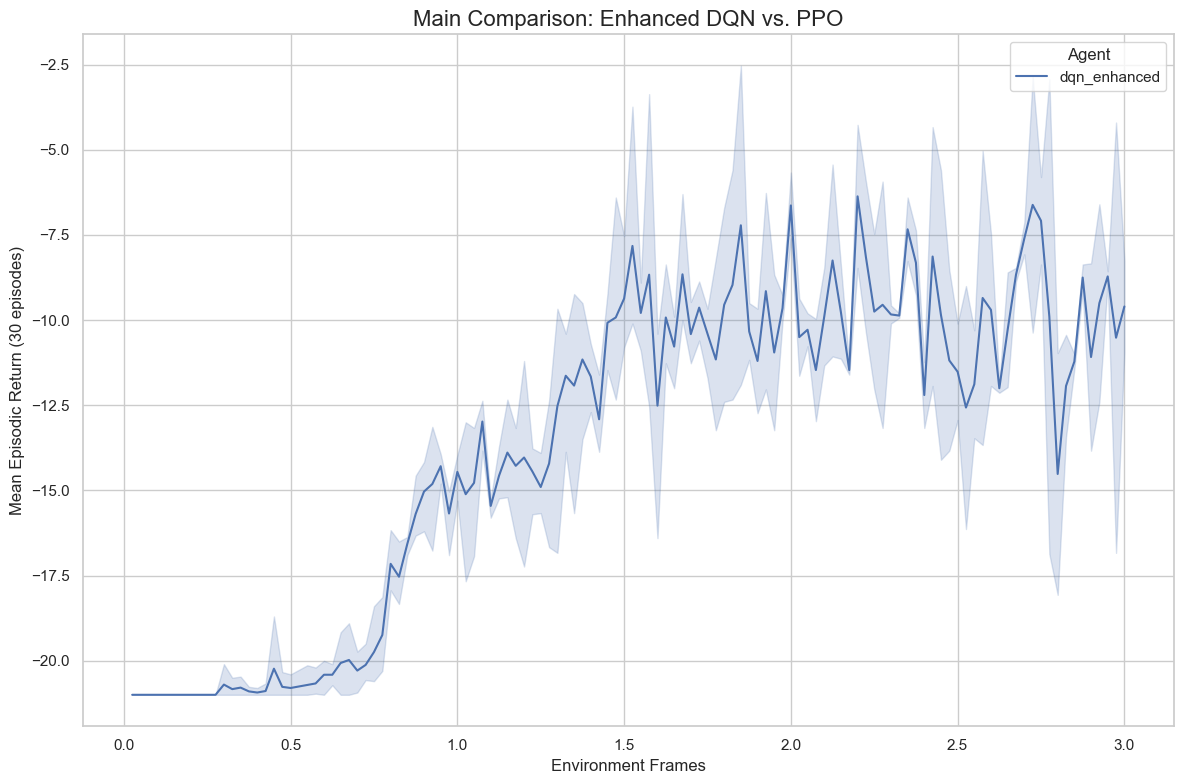

In [3]:
def plot_learning_curves(df, title, x='environment_frame', y='eval_mean_return', hue='agent_name'):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x=x, y=y, hue=hue, errorbar=('ci', 95))
    plt.title(title, fontsize=16)
    plt.xlabel('Environment Frames', fontsize=12)
    plt.ylabel('Mean Episodic Return (30 episodes)', fontsize=12)
    plt.legend(title='Agent')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if 'results_df' in locals() and not results_df.empty:
    eval_df = results_df.dropna(subset=['eval_mean_return'])
    eval_df['environment_frame_millions'] = eval_df['environment_frame'] / 1_000_000

    ablation_df = eval_df[eval_df['agent_name'].isin(['dqn_vanilla', 'dqn_enhanced'])]
    plot_learning_curves(ablation_df, 'Ablation Study: Vanilla DQN vs. Enhanced DQN', x='environment_frame_millions')

    main_comparison_df = eval_df[eval_df['agent_name'].isin(['dqn_enhanced', 'ppo'])]
    plot_learning_curves(main_comparison_df, 'Main Comparison: Enhanced DQN vs. PPO', x='environment_frame_millions')